In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt  # seaborn is based on matplotlib, need this
sns.set(color_codes=True) # adds a nice background to the graphs
%matplotlib inline 

In [2]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)



[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# install openpyxl for reading and writing Excel files on the client-side
!pip install openpyxl


[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import anvil.server
anvil.server.connect("server_OLQA5VCX7NVPVA4I5LZEVKX3-X65WW2MQ5KCRTDJR")
# To read the uploaded data
import anvil.media
# To upload the graph to the client
import anvil.mpl_util
# To upload the processed dataset to the client
from io import BytesIO

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


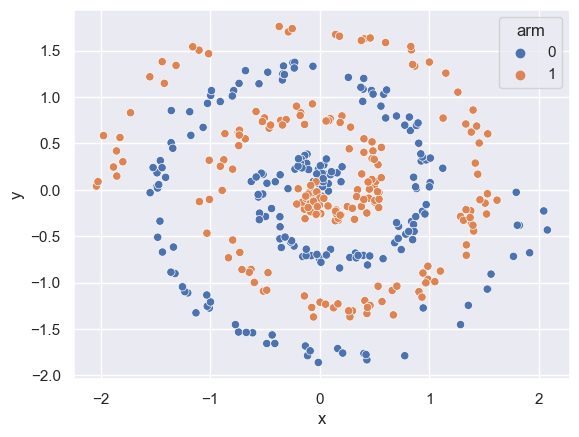

In [5]:
# generate some random points
# there will be 2 loops of each spiral arm
nr = 200
r1 = 2*np.random.uniform(size=nr)
r2 = 2*np.random.uniform(size=nr)

# put them on a circle with radius increasing with angle (to make the first spiral arm)
# also add a little noise for each data point on the arm
# all data points between 0-2
x1 = r1*np.cos(2*np.pi*r1)+0.075*np.random.normal(size=nr)
y1 = r1*np.sin(2*np.pi*r1)+0.075*np.random.normal(size=nr)

# now put the second arm out of phase by 180 degrees
x2 = r2*np.cos(2*np.pi*r2 + np.pi)+0.075*np.random.normal(size=nr)
y2 = r2*np.sin(2*np.pi*r2 + np.pi)+0.075*np.random.normal(size=nr)

# first arm (x1,y1) gets labeled as 0, second arm (x2,y2) gets labeled as 1
arm = [0]*nr+[1]*nr

# combine all data points into a dataframe, x2 appeneded to x1, y2 appended to y1
df = pd.DataFrame({'x':np.concatenate((x1,x2)), 'y':np.concatenate((y1,y2)),'arm':arm})

# plot the data points
sns.scatterplot(data=df,x='x',y='y',hue='arm');

In [6]:
# pandas works well for plotting, but tensorflow needs np arrays
data = df.to_numpy()
# x and y 
xtrain = data[:,0:2]
# arm
ytrain = data[:,2]

In [7]:
# create a test set without the noise, 51 points for each arm
rtest = np.linspace(0,2,num=51)

# put them on a circle with radius increasing with angle (to make the first spiral arm)
x1 = rtest*np.cos(2*np.pi*rtest)
y1 = rtest*np.sin(2*np.pi*rtest)

# now put the second arm out of phase by 180 degrees
x2 = rtest*np.cos(2*np.pi*rtest + np.pi)
y2 = rtest*np.sin(2*np.pi*rtest + np.pi)

# combine x1, x2 and y1, y2 into one multidimensional array (test dataframe)
xtest = np.zeros((102,2))
xtest[0:51,0] = x1
xtest[51:,0] = x2
xtest[0:51,1] = y1
xtest[51:,1] = y2

# first arm (x1,y1) gets labeled as 0, second arm (x2,y2) gets labeled as 1
ytest = np.zeros(102)
ytest[0:51] = 0
ytest[51:] = 1

# x and y, so 2 features
xshape = (2,)

In [8]:
#Sequential model, layers added one at a time, here we use Adam as the optimizer
NNmodel_adam = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32,activation=tf.nn.relu,input_shape=xshape),
    tf.keras.layers.Dense(16,activation=tf.nn.relu),
    tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)])

# Optimizer is the algorithm used to find the best weights
# Learning rate is the lambda in the gradient descent algorithm (for finding the best weights and biases)
# We use binary_crossentropy because we have a binary classification problem
# Metrics is the metric we want to track
NNmodel_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [9]:
# Fit the model to the training data
# Verbose is how much information we want tensorflow to tell us
# The semi-colon at the end suppresses the output
NNmodel_adam.fit(xtrain,ytrain,epochs=400,batch_size=10,validation_data = (xtest,ytest),verbose=2);

Epoch 1/400
40/40 - 0s - loss: 0.7104 - accuracy: 0.5225 - val_loss: 0.6914 - val_accuracy: 0.5588 - 432ms/epoch - 11ms/step
Epoch 2/400
40/40 - 0s - loss: 0.6946 - accuracy: 0.4975 - val_loss: 0.6828 - val_accuracy: 0.5980 - 39ms/epoch - 975us/step
Epoch 3/400
40/40 - 0s - loss: 0.6886 - accuracy: 0.5825 - val_loss: 0.6746 - val_accuracy: 0.6078 - 38ms/epoch - 950us/step
Epoch 4/400
40/40 - 0s - loss: 0.6809 - accuracy: 0.5675 - val_loss: 0.6697 - val_accuracy: 0.6275 - 41ms/epoch - 1ms/step
Epoch 5/400
40/40 - 0s - loss: 0.6679 - accuracy: 0.6050 - val_loss: 0.6540 - val_accuracy: 0.5980 - 42ms/epoch - 1ms/step
Epoch 6/400
40/40 - 0s - loss: 0.6364 - accuracy: 0.6175 - val_loss: 0.6205 - val_accuracy: 0.6569 - 39ms/epoch - 975us/step
Epoch 7/400
40/40 - 0s - loss: 0.6058 - accuracy: 0.6425 - val_loss: 0.5922 - val_accuracy: 0.6078 - 38ms/epoch - 950us/step
Epoch 8/400
40/40 - 0s - loss: 0.5934 - accuracy: 0.6375 - val_loss: 0.5721 - val_accuracy: 0.6765 - 39ms/epoch - 975us/step
Epoc

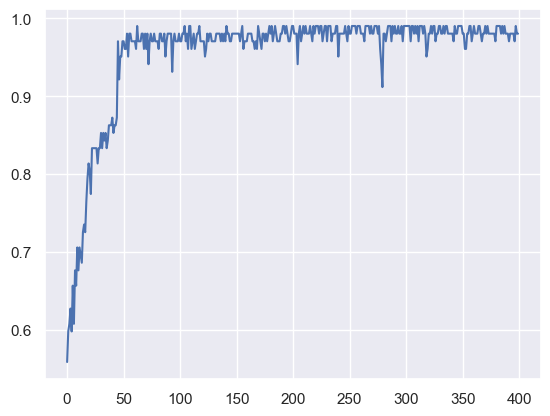

In [10]:
# Better validaton accuracy using Adam optimizer than Adagrad optimizer earlier
sns.lineplot(x=range(len(NNmodel_adam.history.history['val_accuracy'])),y=NNmodel_adam.history.history['val_accuracy']);

In [11]:
# Create a grid of 51x51 points
grid = np.linspace(-2,2,num=51)
xg = np.zeros(51**2)
yg = np.zeros(51**2)
k=0
# Loop over all combinations of x and y
for x in range(51):
    for y in range(51):
        xg[k]=grid[x]
        yg[k]=grid[y]
        k+=1

# Create an array to hold the x and y values
xy = np.zeros((51**2,2))
# Put the x and y values into the xy array
xy[:,0]=xg
xy[:,1]=yg

82/82 [==============================] - 0s 778us/step


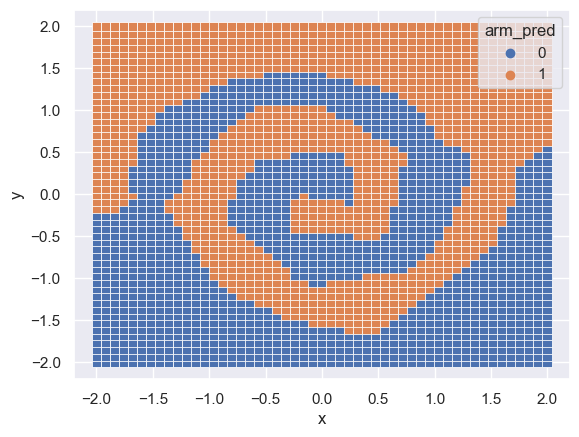

In [12]:
pred_adam = (NNmodel_adam.predict(xy)>0.5).astype(int)

# Plot the predictions, need transposing because the predictions are a column vector, not a row vector
df_adam = pd.DataFrame({'x':xg,'y':yg,'arm_pred':pred_adam.transpose()[0]})
sns.scatterplot(data=df_adam,x='x',y='y',hue='arm_pred',s=50,marker='s');

In [13]:
# Predict which arm a x and y coordinate is in
df_hw = pd.read_csv('xy_locs.csv')
xy_hw = df_hw[['x','y']].to_numpy()
pred_hw = (NNmodel_adam.predict(xy_hw)>0.5).astype(int)
pred_hw.transpose()[0]
# put the predictions into the dataframe
df_new = pd.DataFrame({'x':xy_hw[:,0],'y':xy_hw[:,1]})
df_new['arm_pred'] = pred_hw.transpose()[0]
df_new

1/1 [==============================] - 0s 20ms/step


,x,y,arm_pred
0,-0.382115,0.799741,1
1,-0.042117,-0.689008,0
2,0.103946,0.774758,1
3,-0.797641,0.252785,1
4,-0.543082,0.000887,0
5,0.569336,-0.260558,1
6,-0.323797,0.260914,0
7,-0.293407,-1.714093,0
8,1.460393,0.137136,1
9,0.944145,0.025133,0


In [14]:
# Function to upload a processed dataset 
@anvil.server.callable
def get_file(file):
    with anvil.media.TempFile(file) as filename:
        df = pd.read_csv(filename)
    # Turn pandas dataframe into numpy array
    xy = df[['x','y']].to_numpy()
    return xy

In [15]:
#Function to upload graphical solution
@anvil.server.callable
def get_graph(xy):
    # change list to numpy array
    xy = np.array(xy)
    pred = (NNmodel_adam.predict(xy)>0.5).astype(int)
    pred = pred.transpose()[0]
    # plot the predictions
    df = pd.DataFrame({'x':xy[:,0],'y':xy[:,1],'arm_pred':pred})
    sns.scatterplot(data=df,x='x',y='y',hue='arm_pred',s=50);
    # clear legend
    plt.legend([],[], frameon=False)
    # Add legend
    plt.legend(loc='lower right', labels=['Arm 1', 'Arm 0'])
    return anvil.mpl_util.plot_image()

In [16]:
# Function to upload a CSV file
@anvil.server.callable
def get_csv(xy):
    # change list to numpy array
    xy = np.array(xy)
    pred = (NNmodel_adam.predict(xy)>0.5).astype(int)
    pred = pred.transpose()[0]
    # plot the predictions
    df = pd.DataFrame({'x':xy[:,0],'y':xy[:,1],'arm_pred':pred})
    content = BytesIO()
    # convert dataframe to excel
    df.to_excel(content,index=False)
    # create a media object from the excel file
    name = 'points_classifications.xlsx'
    content.seek(0, 0)
    content_type = "application/vnd.ms-excel"
    media_object = anvil.BlobMedia(content_type=content_type, content=content.read(), name=name)
    return media_object